<a href="https://colab.research.google.com/github/Chithiralasuchi/Spam-detection/blob/main/sms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import random
import os
import re
from wordcloud import WordCloud
from collections import Counter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('punkt')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!pip install wordcloud
# Feature Extraction & Text Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data Preprocessing & Scaling
from sklearn.preprocessing import StandardScaler


# Model Training & Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split

from sklearn.metrics import (
    accuracy_score, precision_score,
     confusion_matrix, classification_report,precision_recall_curve,roc_curve,auc
)

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


Data Loading and Exploration

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# Display basic dataset info
print("\n----- Dataset Overview -----")
print("Dataset shape:", df.shape)
print("First 5 rows:\n", df.head(5))


----- Dataset Overview -----
Dataset shape: (5572, 5)
First 5 rows:
      v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [ ]:
# Keep only relevant columns and rename them to label and message
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

# Convert labels to numerical format
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

<ipython-input-5-a6a5e59729fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map({'ham': 0, 'spam': 1})


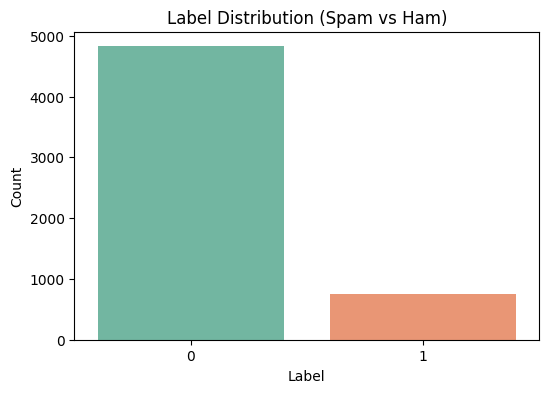

In [ ]:
# Visualizing the distribution of labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title("Label Distribution (Spam vs Ham)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

Feature Engineering

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
df["No_of_Characters"] =df["message"].apply(len)
df["No_of_Words"]=df.apply(lambda row: word_tokenize(row["message"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: sent_tokenize(row["message"]), axis=1).apply(len)

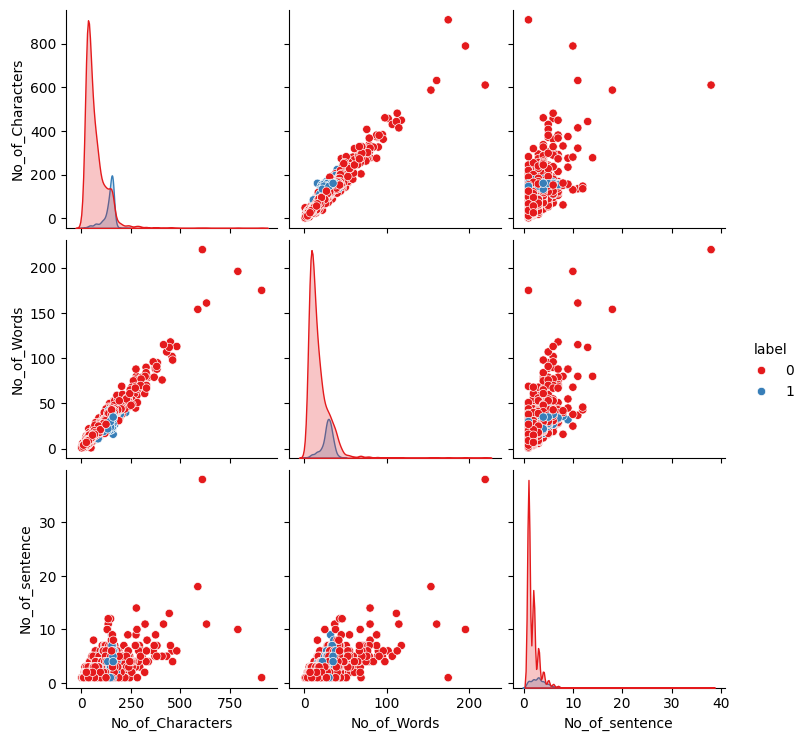

In [ ]:
# Only select numerical columns for pairplot
numerical_columns = ['No_of_Characters', 'No_of_Words', 'No_of_sentence']

# Plot pairplot with numerical columns only and color points based on 'label'
sns.pairplot(df[numerical_columns + ['label']], hue='label', palette='Set1')

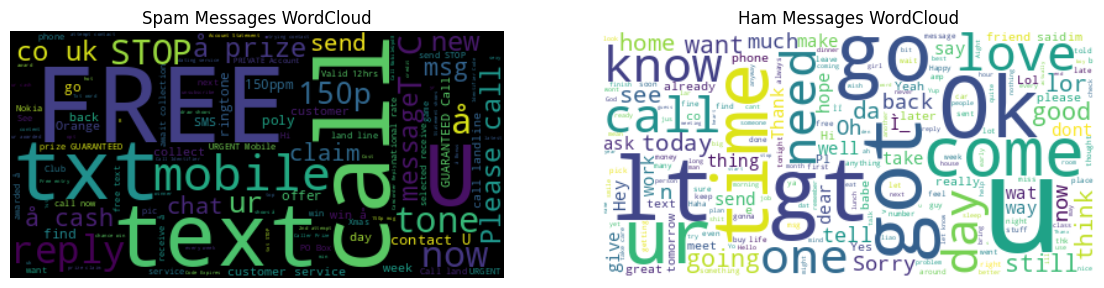


Top spam words: [('good', np.int64(195)), ('ll', np.int64(134)), ('lt', np.int64(119)), ('got', np.int64(109)), ('know', np.int64(109)), ('like', np.int64(108)), ('come', np.int64(96)), ('just', np.int64(96)), ('ok', np.int64(83)), ('gt', np.int64(82))]
Top ham words: [('gt', np.int64(288)), ('lt', np.int64(287)), ('just', np.int64(278)), ('ok', np.int64(255)), ('ll', np.int64(232)), ('got', np.int64(226)), ('know', np.int64(225)), ('like', np.int64(222)), ('good', np.int64(215)), ('come', np.int64(211))]


In [ ]:
stop_words = set(stopwords.words('english'))
# WordCloud for spam and ham messages
spam_words = ' '.join(df[df['label'] == 1]['message'])
ham_words = ' '.join(df[df['label'] == 0]['message'])

# Remove stopwords for better word cloud generation
spam_words_cleaned = ' '.join([word for word in spam_words.split() if word.lower() not in stop_words])
ham_words_cleaned = ' '.join([word for word in ham_words.split() if word.lower() not in stop_words])

# Plot WordCloud
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=400, height=200, background_color='black').generate(spam_words_cleaned)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Spam Messages WordCloud")

plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=400, height=200, background_color='white').generate(ham_words_cleaned)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title("Ham Messages WordCloud")

plt.show()

# Top spam vs ham words using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)

# Fit and transform on spam and ham messages
spam_vectorized = vectorizer.fit_transform(df[df['label'] == 1]['message'])
ham_vectorized = vectorizer.fit_transform(df[df['label'] == 0]['message'])

# Get the top 10 words for spam and ham
spam_word_freq = sorted(zip(vectorizer.get_feature_names_out(), spam_vectorized.sum(axis=0).A1), key=lambda x: x[1], reverse=True)
ham_word_freq = sorted(zip(vectorizer.get_feature_names_out(), ham_vectorized.sum(axis=0).A1), key=lambda x: x[1], reverse=True)

# Print top words
print("\nTop spam words:", spam_word_freq[:10])
print("Top ham words:", ham_word_freq[:10])

Text Preprocessing

In [ ]:
# Check for missing values and duplicates
print("\n----- Data Quality Check -----")
print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)
print("New dataset shape after removing duplicates:", df.shape)


----- Data Quality Check -----
Missing values:
 label               0
message             0
No_of_Characters    0
No_of_Words         0
No_of_sentence      0
dtype: int64
Duplicate rows: 0
New dataset shape after removing duplicates: (5169, 5)


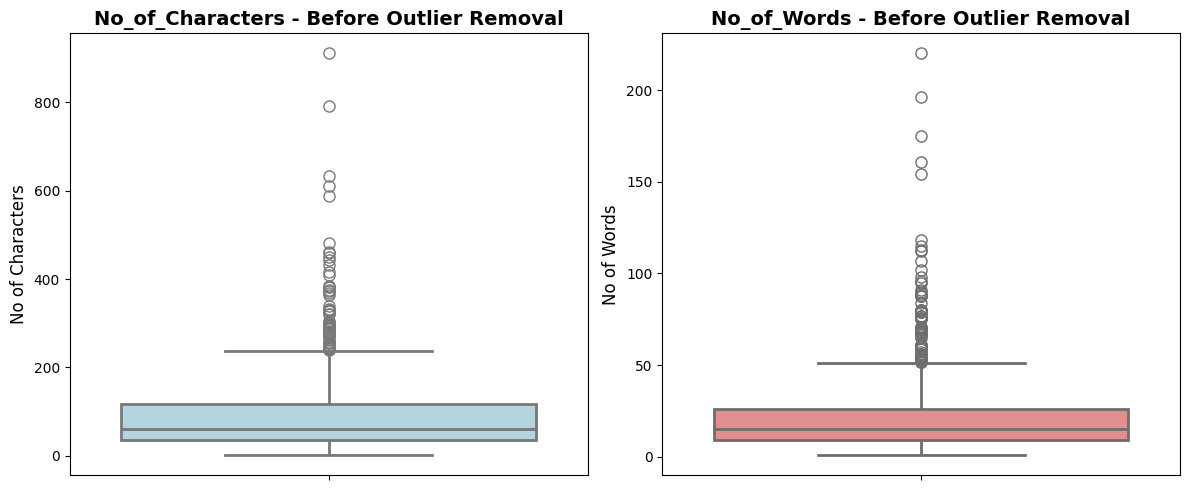

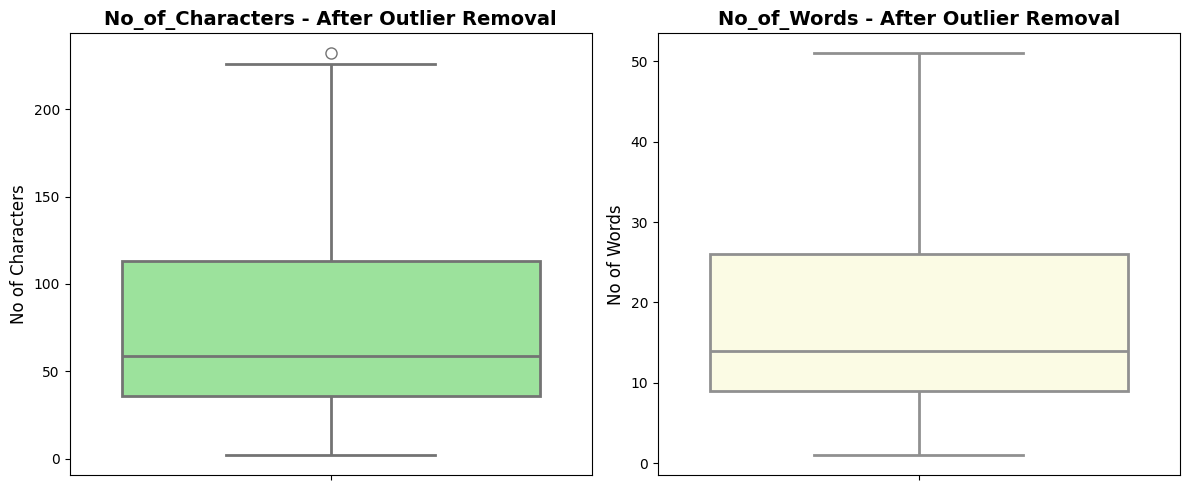

In [ ]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Plot boxplots before removing outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df["No_of_Characters"], ax=axes[0], color="lightblue", fliersize=8, linewidth=2)
axes[0].set_title("No_of_Characters - Before Outlier Removal", fontsize=14, fontweight='bold')
axes[0].set_ylabel("No of Characters", fontsize=12)

sns.boxplot(y=df["No_of_Words"], ax=axes[1], color="lightcoral", fliersize=8, linewidth=2)
axes[1].set_title("No_of_Words - Before Outlier Removal", fontsize=14, fontweight='bold')
axes[1].set_ylabel("No of Words", fontsize=12)

plt.tight_layout()
plt.show()

# Apply function to remove outliers
df_cleaned = remove_outliers_iqr(df, "No_of_Characters")
df_cleaned = remove_outliers_iqr(df_cleaned, "No_of_Words")

# Plot boxplots after removing outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df_cleaned["No_of_Characters"], ax=axes[0], color="lightgreen", fliersize=8, linewidth=2)
axes[0].set_title("No_of_Characters - After Outlier Removal", fontsize=14, fontweight='bold')
axes[0].set_ylabel("No of Characters", fontsize=12)

sns.boxplot(y=df_cleaned["No_of_Words"], ax=axes[1], color="lightyellow", fliersize=8, linewidth=2)
axes[1].set_title("No_of_Words - After Outlier Removal", fontsize=14, fontweight='bold')
axes[1].set_ylabel("No of Words", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetical characters but keep numbers and spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Tokenize text
    words = word_tokenize(text)

    # Get POS tags
    pos_tags = pos_tag(words)

    # Lemmatize using POS tags
    words = [lemmatizer.lemmatize(word, pos='v' if tag.startswith('V')
     else
                                 ('n' if tag.startswith('NN') else
                                  ('a' if tag.startswith('JJ') else
                                   ('r' if tag.startswith('RB') else 'n'))))
            for word, tag in pos_tags]

    # Rejoin words into a cleaned sentence
    return ' '.join(words)

# Apply preprocessing to clean the message
df['clean_message'] = df['message'].apply(preprocess_text)

In [ ]:
# Display the first cleaned message
print("Original Message: ", df['message'].iloc[0])
print("Cleaned Message: ", df['clean_message'].iloc[0])

Original Message:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Cleaned Message:  go until jurong point crazy available only in bugis n great world la e buffet cine there get amore wat


Naive Bayes

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

Multinomial Naive Bayes (TF-IDF):
Accuracy: 0.9458413926499033

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       889
           1       1.00      0.61      0.76       145

    accuracy                           0.95      1034
   macro avg       0.97      0.81      0.87      1034
weighted avg       0.95      0.95      0.94      1034

Multinomial Naive Bayes (CountVectorizer):
Accuracy: 0.9796905222437138

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.87      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034



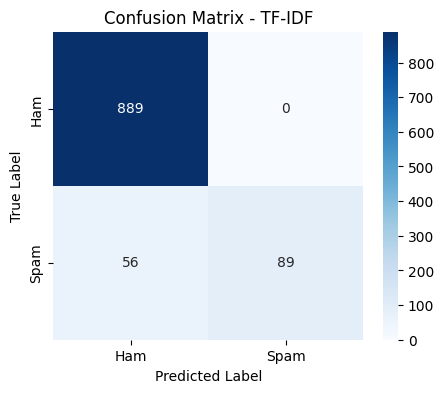

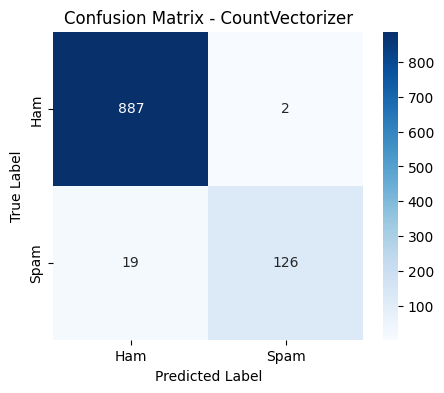

In [ ]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(df['clean_message'], df['label'], test_size=0.2, random_state=SEED)

# Feature extraction using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))  # Use unigrams and bigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Multinomial Naive Bayes with TF-IDF
print("Multinomial Naive Bayes (TF-IDF):")
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = mnb_tfidf.predict(X_test_tfidf)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tfidf))


# Feature extraction using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))  # Use unigrams and bigrams
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)

# Multinomial Naive Bayes with CountVectorizer
print("Multinomial Naive Bayes (CountVectorizer):")
mnb_cv = MultinomialNB()
mnb_cv.fit(X_train_cv, y_train)
y_pred_cv = mnb_cv.predict(X_test_cv)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_cv))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cv))
# Plot confusion matrix for TF-IDF
plot_confusion_matrix(y_test, y_pred_tfidf, "Confusion Matrix - TF-IDF")

# Plot confusion matrix for CountVectorizer
plot_confusion_matrix(y_test, y_pred_cv, "Confusion Matrix - CountVectorizer")


Top Features

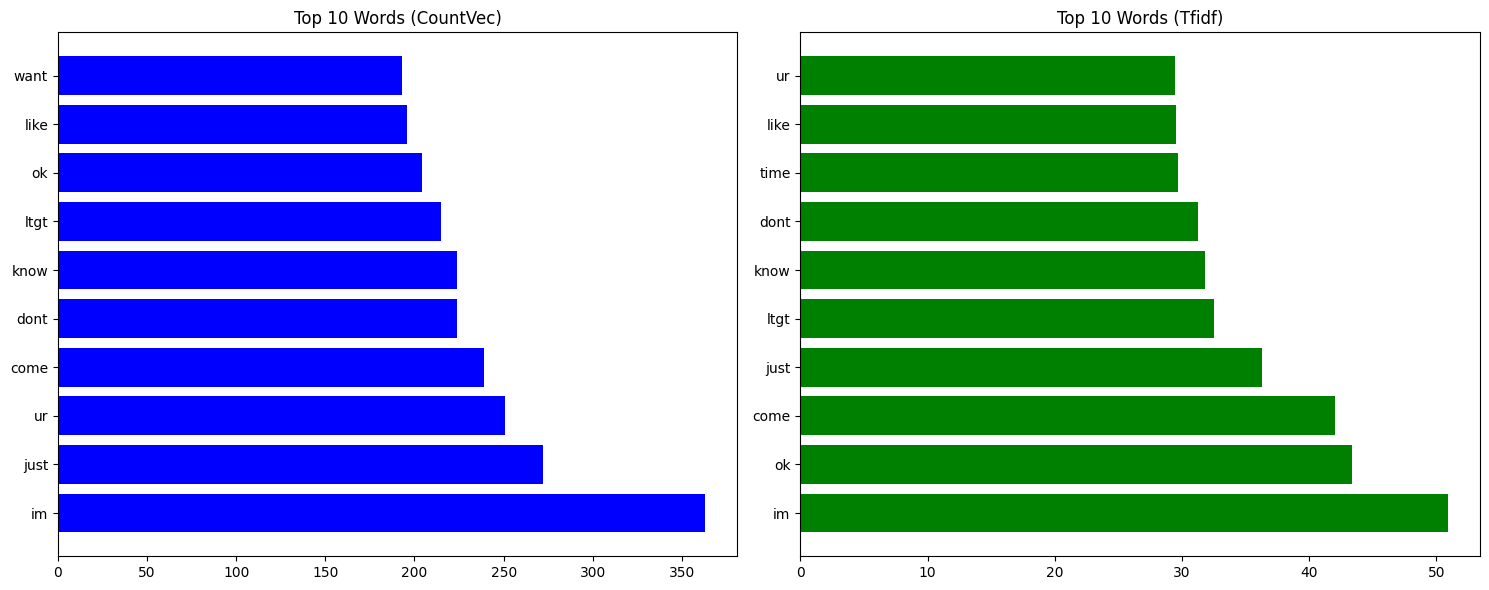

In [ ]:
# Get top words from CountVectorizer
count_terms = count_vectorizer.get_feature_names_out()
count_word_freq = X_train_cv.sum(axis=0).A1
count_term_freq = list(zip(count_terms, count_word_freq))
count_term_freq = sorted(count_term_freq, key=lambda x: x[1], reverse=True)

# Get top words from TfidfVectorizer
tfidf_terms = tfidf_vectorizer.get_feature_names_out()
tfidf_word_freq = X_train_tfidf.sum(axis=0).A1
tfidf_term_freq = list(zip(tfidf_terms, tfidf_word_freq))
tfidf_term_freq = sorted(tfidf_term_freq, key=lambda x: x[1], reverse=True)

# Plot the top 10 frequent words for both
top_count_terms = [x[0] for x in count_term_freq[:10]]
top_count_values = [x[1] for x in count_term_freq[:10]]

top_tfidf_terms = [x[0] for x in tfidf_term_freq[:10]]
top_tfidf_values = [x[1] for x in tfidf_term_freq[:10]]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].barh(top_count_terms, top_count_values, color='b')
ax[0].set_title("Top 10 Words (CountVec)")

ax[1].barh(top_tfidf_terms, top_tfidf_values, color='g')
ax[1].set_title("Top 10 Words (Tfidf)")

plt.tight_layout()
plt.show()

SMOTE

Multinomial Naive Bayes (Tfidf) with SMOTE:
Accuracy: 0.9671179883945842

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       889
           1       0.84      0.95      0.89       145

    accuracy                           0.97      1034
   macro avg       0.91      0.96      0.94      1034
weighted avg       0.97      0.97      0.97      1034

Multinomial Naive Bayes (CountVec) with SMOTE:
Accuracy: 0.9690522243713733

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       889
           1       0.87      0.91      0.89       145

    accuracy                           0.97      1034
   macro avg       0.93      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034



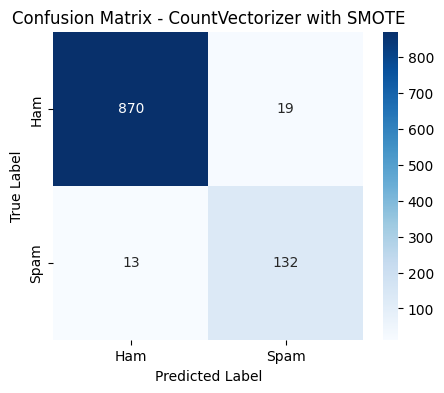

In [ ]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=SEED)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Multinomial Naive Bayes with TfidfVectorizer
print("Multinomial Naive Bayes (Tfidf) with SMOTE:")
mnb = MultinomialNB()
mnb.fit(X_train_tfidf_resampled, y_train_resampled)
y_pred_mnb = mnb.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_mnb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_mnb))

# Feature extraction using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

# Apply SMOTE to balance the training set for CountVectorizer features
X_train_cv_resampled, y_train_cv_resampled = smote.fit_resample(X_train_cv, y_train)

# Multinomial Naive Bayes with CountVectorizer
print("Multinomial Naive Bayes (CountVec) with SMOTE:")
mnb = MultinomialNB()
mnb.fit(X_train_cv_resampled, y_train_cv_resampled)
y_pred_cv = mnb.predict(X_test_cv)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_cv))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cv))

# Plot confusion matrix for CountVectorizer with SMOTE
plot_confusion_matrix(y_test, y_pred_cv, "Confusion Matrix - CountVectorizer with SMOTE")

Logistic Regression

In [ ]:
# Compute class weights
classes = y_train.unique()
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Apply SMOTE to balance the training set (TF-IDF)
smote = SMOTE(random_state=SEED)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Logistic Regression with class weights (TF-IDF)
print("Logistic Regression (TF-IDF) with SMOTE & Class Weights:")
log_reg_tfidf = LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=SEED)
log_reg_tfidf.fit(X_train_tfidf_resampled, y_train_resampled)
y_pred_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tfidf))


# Feature extraction using CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)

# Apply SMOTE to balance the training set (CountVectorizer)
X_train_cv_resampled, y_train_cv_resampled = smote.fit_resample(X_train_cv, y_train)

# Logistic Regression with class weights (CountVectorizer)
print("Logistic Regression (CountVec) with SMOTE & Class Weights:")
log_reg_cv = LogisticRegression(class_weight=class_weight_dict, max_iter=1000)
log_reg_cv.fit(X_train_cv_resampled, y_train_cv_resampled)
y_pred_cv = log_reg_cv.predict(X_test_cv)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_cv))
print("\nClassification Report:\n", classification_report(y_test, y_pred_cv))

Logistic Regression (TF-IDF) with SMOTE & Class Weights:
Accuracy: 0.9448742746615088

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       889
           1       0.73      0.97      0.83       145

    accuracy                           0.94      1034
   macro avg       0.86      0.95      0.90      1034
weighted avg       0.96      0.94      0.95      1034

Logistic Regression (CountVec) with SMOTE & Class Weights:
Accuracy: 0.7379110251450677

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82       889
           1       0.34      0.90      0.49       145

    accuracy                           0.74      1034
   macro avg       0.66      0.81      0.66      1034
weighted avg       0.89      0.74      0.78      1034



Train Various Models(Using cross validation)

In [ ]:
# Initialize Stratified K-Fold (5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [ ]:
# Define classifiers with class weights
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(class_weight=class_weight_dict, max_iter=1000, random_state=SEED),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=SEED),
    "SVM": SVC(probability=True, kernel="linear", class_weight=class_weight_dict, random_state=SEED)
}

# Store results
cv_results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    scores = cross_val_score(clf, X_train_cv_resampled, y_train_cv_resampled, cv=cv, scoring='accuracy')
    cv_results[name] = scores.mean()
    clf.fit(X_train_cv_resampled, y_train_cv_resampled)
    y_pred = clf.predict(X_test_cv)

    # Print evaluation metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Store predictions for visualization
    classifiers[name] = (clf, y_pred)


Training MultinomialNB...
Accuracy: 0.9691

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       889
           1       0.87      0.91      0.89       145

    accuracy                           0.97      1034
   macro avg       0.93      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034


Training LogisticRegression...
Accuracy: 0.7379

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82       889
           1       0.34      0.90      0.49       145

    accuracy                           0.74      1034
   macro avg       0.66      0.81      0.66      1034
weighted avg       0.89      0.74      0.78      1034


Training RandomForest...
Accuracy: 0.8549

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91       889
           1       0.49   

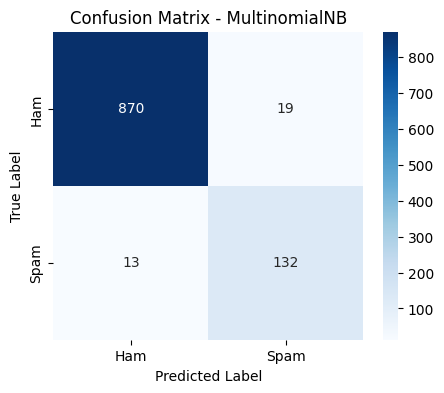

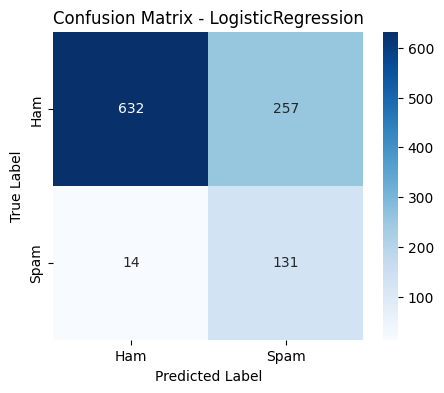

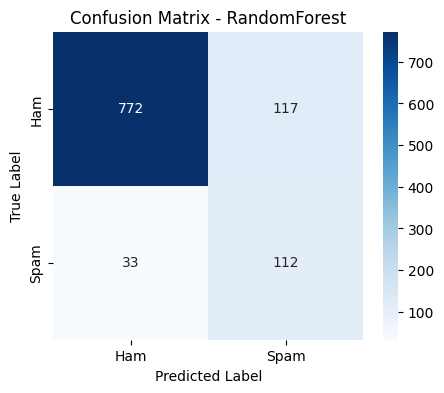

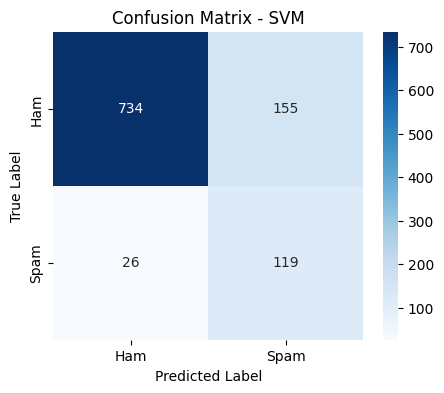

In [ ]:
# Plot confusion matrices
for name, (clf, y_pred) in classifiers.items():
    plot_confusion_matrix(y_test, y_pred, f"Confusion Matrix - {name}")

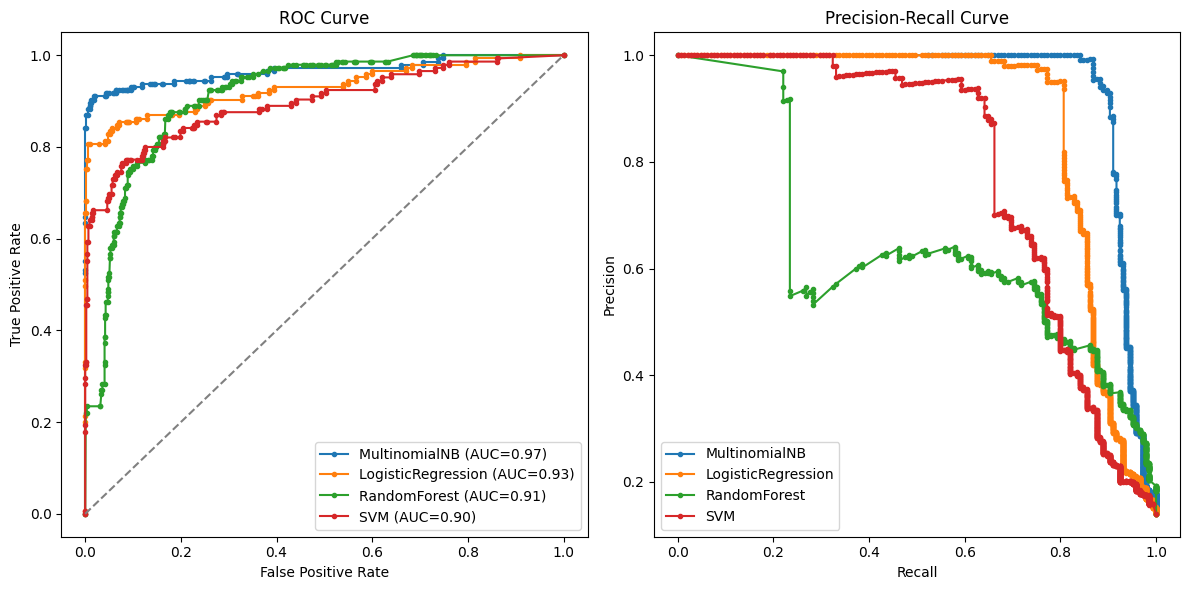

In [ ]:
def plot_roc_pr_curve(y_true, classifiers, X_test_cv):
    # Create subplots: one row, two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Loop through each classifier
    for name, (clf, _) in classifiers.items():
        if hasattr(clf, "predict_proba"):  # Only classifiers that support probability prediction
            # ROC Curve
            y_probs = clf.predict_proba(X_test_cv)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, marker=".", label=f"{name} (AUC={roc_auc:.2f})")

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_true, y_probs)
            ax2.plot(recall, precision, marker=".", label=f"{name}")

    # ROC Curve settings
    ax1.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("ROC Curve")
    ax1.legend()

    # Precision-Recall Curve settings
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("Precision-Recall Curve")
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call the function with classifiers and X_test_cv
plot_roc_pr_curve(y_test, classifiers, X_test_cv)

Deep Learning(LSTM & GRU)

In [ ]:
# Plot results for LSTM and GRU
def plot_history(history_list, model_name):
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for history in history_list:
        plt.plot(history['val_accuracy'], label="Val")
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for history in history_list:
        plt.plot(history['val_loss'], label="Val")
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot validation accuracy for LSTM and GRU
def plot_validation_accuracy(history_folds, model_name):
    val_accs = [max(hist['val_accuracy']) for hist in history_folds]
    plt.plot(range(1, len(val_accs) + 1), val_accs, label=model_name)
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy for {model_name}')
    plt.xticks(range(1, len(val_accs) + 1))
    plt.legend()
    plt.show()

In [ ]:
# Set parameters
max_words = 5000  # Maximum number of words in the vocabulary
max_len = 100  # Maximum length of input sequences
embedding_dim = 100  # Dimension of the word embeddings
SEED = 42

# Initialize the tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_message'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_message'])

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = np.array(df['label'])

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Function to create LSTM model
def create_lstm_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Function to create GRU model
def create_gru_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim),
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(GRU(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Prepare StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# List to store the history objects for each fold for both models
history_lstm_folds = []
history_gru_folds = []

# Best validation accuracy tracking for selecting the best model
best_lstm_val_acc = 0
best_gru_val_acc = 0
best_lstm_model = None
best_gru_model = None

# Iterate through folds and perform cross-validation for both LSTM and GRU
for fold, (train_index, val_index) in enumerate(kf.split(X,y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize and fit LSTM model
    lstm_model = create_lstm_model()
    print(f"Training LSTM for fold {fold}")
    history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, class_weight=class_weights_dict)
    history_lstm_folds.append(history_lstm.history)

    # Track best LSTM model based on validation accuracy
    val_acc_lstm = max(history_lstm.history['val_accuracy'])
    if val_acc_lstm > best_lstm_val_acc:
        best_lstm_val_acc = val_acc_lstm
        best_lstm_model = lstm_model

    # Initialize and fit GRU model
    gru_model = create_gru_model()
    print(f"Training GRU for fold {fold}")
    history_gru = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, class_weight=class_weights_dict)
    history_gru_folds.append(history_gru.history)

    # Track best GRU model based on validation accuracy
    val_acc_gru = max(history_gru.history['val_accuracy'])
    if val_acc_gru > best_gru_val_acc:
        best_gru_val_acc = val_acc_gru
        best_gru_model = gru_model

Training LSTM for fold 1
Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.6856 - loss: 0.4685 - val_accuracy: 0.9787 - val_loss: 0.0906
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.9835 - loss: 0.0940 - val_accuracy: 0.9787 - val_loss: 0.0767
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.9941 - loss: 0.0372 - val_accuracy: 0.9700 - val_loss: 0.1294
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 39s 216ms/step - accuracy: 0.9952 - loss: 0.0203 - val_accuracy: 0.9749 - val_loss: 0.0882
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.9984 - loss: 0.0094 - val_accuracy: 0.9778 - val_loss: 0.1022
Training GRU for fold 1
Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.6427 - loss: 0.5024 - val_accuracy: 0.9671 - val_loss: 0.1124
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.9824 - loss: 0.0879 - val_accuracy: 0.9807 - val_loss: 0.0821
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 41

In [ ]:
best_lstm_val_acc

0.9864603281021118

In [ ]:
best_gru_val_acc

0.9864603281021118

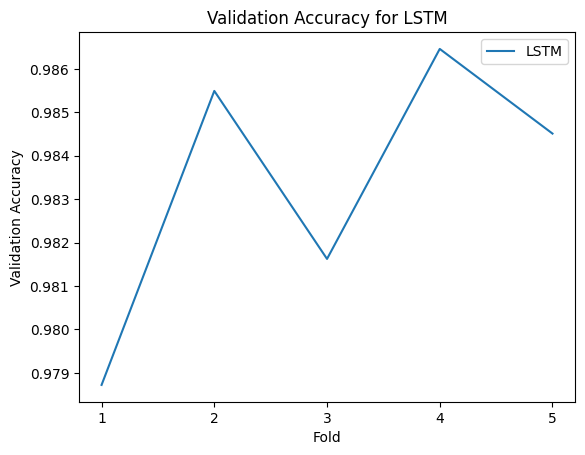

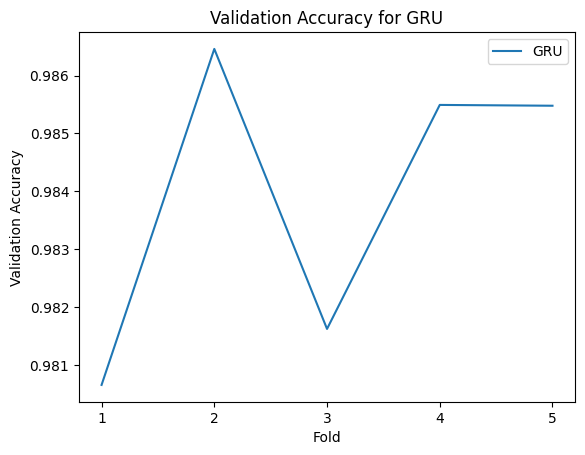

In [ ]:
plot_validation_accuracy(history_lstm_folds, "LSTM")
plot_validation_accuracy(history_gru_folds, "GRU")

Evaluate DL Models

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
Confusion Matrix for Best LSTM Model


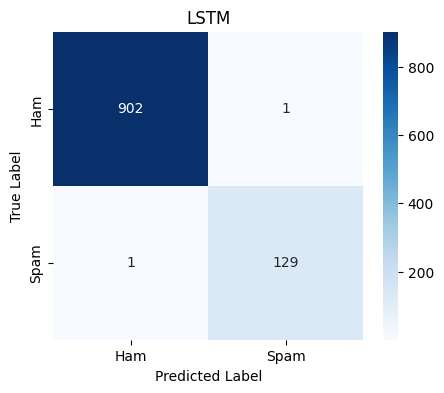

Confusion Matrix for Best GRU Model


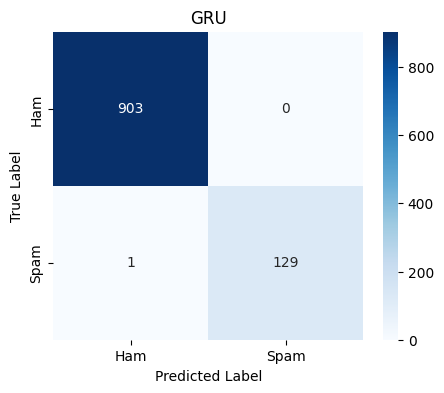

In [ ]:
y_pred_lstm=best_lstm_model.predict(X_val)
y_pred_lstm=(y_pred_lstm>0.5).astype(int)

y_pred_gru=best_gru_model.predict(X_val)
y_pred_gru=(y_pred_gru>0.5).astype(int)
# Plot confusion matrix for best LSTM model
print("Confusion Matrix for Best LSTM Model")
plot_confusion_matrix(y_val,y_pred_lstm ,"LSTM")

# Plot confusion matrix for best GRU model
print("Confusion Matrix for Best GRU Model")
plot_confusion_matrix( y_val,y_pred_gru, "GRU")

In [ ]:
from google.colab import drive
drive.mount('https://colab.research.google.com/drive/1rlK7fZiilaBrck411dAOeljMwHfY5JP0?usp=drive_link')

ValueError: Mountpoint must be in a directory that exists